# Bayesian Parametric Regression

    Notebook version: 1.3 (Sep 26, 2016)

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid-Sueiro (jesus.cid@uc3m.es)

    Changes: v.1.0 - First version
             v.1.1 - ML Model selection included
             v.1.2 - Some typos corrected
             v.1.3 - Rewriting text, reorganizing content, some exercises.
    
    Pending changes: * Include regression on the stock data

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 
from IPython import display

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
import pylab
import time

/Users/jcid/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## 1. Model-based parametric regression

### 1.1. The regression problem.

Given an observation vector ${\bf x}$, the goal of the regression problem is to find a function $f({\bf x})$ providing *good* predictions about some unknown variable $s$. To do so, we assume that a set of *labelled* training examples, $\{{\bf x}^{(k)}, s^{(k)}\}_{k=1}^K$ is available. 

The predictor function should make good predictions for new observations ${\bf x}$ not used during training. In practice, this is tested using a second set (the *test set*) of labelled samples.

NOTE: In the following, we will use capital letters, ${\bf X}$, $S$, ..., to denote random variables, and lower-case letters ${\bf x}$, s, ..., to the denote the values they can take. When there is no ambigüity, we will remove subindices of the density functions, $p_{{\bf X}, S}({\bf x}, s)= p({\bf x}, s)$ to simplify the mathematical notation.

### 1.2. Model-based parametric regression

Model-based regression methods assume that all data in the training and test dataset habe been generated by some stochastic process. In parametric regression, we assume that the probability distribution generating the data has a known parametric form, but the values of some parameters are unknown. 

In particular, in this notebook we will assume the target variables in all pairs $({\bf x}^{(k)}, s^{(k)})$ from the training and test sets have been generated independently from some posterior distribution $p(s| {\bf x}, {\bf w})$, were ${\bf w}$ is some unknown parameter. The training dataset is used to estimate ${\bf w}$. 

Once $p(s|{\bf x},{\bf w})$ is known or can be estimated, Estimation Theory can be applied to estimate $s$ for any input ${\bf x}$. For instance, any of these classical estimates can be used:

* Maximum A Posterior (MAP): $\qquad\hat{s}_{\text{MAP}} = \arg\max_s p(s| {\bf x}, {\bf w})$
* Minimum Mean Square Error (MSE): $\qquad\hat{s}_{\text{MSE}} = \mathbb{E}\{S |{\bf x}, {\bf w}\}$

<img src="figs/ParametricReg.png", width=300>


#### 1.3.1. Maximum Likelihood (ML) parameter estimation

One way to estimate ${\bf w}$ is to apply the maximum likelihood principle: take the value ${\bf w}_\text{ML}$ maximizing the joint distribution of the target variables given the inputs and given ${\bf w}$, i.e.

$$
{\bf w}_\text{ML} = \arg\max_{\bf w} p({\bf s}|{\bf X}, {\bf w})
$$

where ${\bf s} = \left(s^{(1)}, \dots, s^{(K)}\right)^\top$ is the vector of target variables and ${\bf X} = \left({\bf x}^{(1)}, \dots, {\bf x}^{(K)}\right)^\top$ is the input matrix.

NOTE: Since the training data inputs are known, all probability density functions and expectations in the remainder of this notebook will be conditioned on ${\bf X}$. To simplify the mathematical notation, from now on we will remove ${\bf X}$ from all conditions. Keep in mind that, in any case, all probabilities and expectations may depend on ${\bf X}$ implicitely.


#### 1.3.2. The Gaussian case

A particularly interesting case arises when the data model is Gaussian:

$$p(s|{\bf x}, {\bf w}) = 
    \frac{1}{\sqrt{2\pi}\sigma_\varepsilon}
    \exp\left(-\frac{(s-{\bf w}^\top{\bf z})^2}{2\sigma_\varepsilon^2}\right)
$$

where ${\bf z}=T({\bf x})$ is a vector with components which can be computed directly from the observed variables. Such expression includes a linear regression model, where ${\bf z} = [1; {\bf x}]$, as well as any other non-linear model as long as it can be expressed as a <i>"linear in the parameters"</i> model.

In that case, it can be shown that the likelihood function $p({\bf s}| {\bf w})$ ($\equiv p({\bf s}| {\bf X}, {\bf w})$) is given by

$$
p({\bf s}| {\bf w})
    = \left(\frac{1}{\sqrt{2\pi}\sigma_\varepsilon}\right)^K
      \exp\left(-\frac{1}{2\sigma_\varepsilon^2}\|{\bf s}-{\bf Z}{\bf w}\|^2\right)
$$

which is maximum for the Least Squares solution

$$
{\bf w}_{ML} = ({\bf Z}^\top{\bf Z})^{-1}{\bf Z}^\top{\bf s}
$$

### 1.4. Limitations of the ML estimators.

Since the ML estimation is equivalent to the LS solution under a Gaussian data model, it has the same drawbacks of LS regression. In particular, ML estimation is prone to overfiting. In general, if the number of parameters (i.e. the dimension of ${\bf w}$) is large in relation to the size of the training data, the predictor based on the ML estimate may have a small square error over the training set but a large error over the test set. Therefore, in practice, som cross validation procedures is required to keep the complexity of the predictor function under control depending on the size of the training set.


## 2. Bayesian Regression

One of the reasons why the ML estimate is prone to overfitting is that the prediction function uses ${\bf w}_\text{ML}$ without taking into account how much uncertain the true value of ${\bf w}$ is.

Bayesian methods utilize such information but considering ${\bf w}$ as a random variable with some prior distribution $p({\bf w})$. The posterior distribution $p({\bf w}|{\bf s})$ will be our measure of the uncertainty about the true value of the model parameters. 

In fact, this posterior distribution is a key component of the predictor function. Indeed, the minimum MSE estimate can be computed as

$$
\hat{s}_\text{MSE} 
   = \mathbb{E}\{s|{\bf s}, {\bf x}\}
   = \int \mathbb{E}\{s|{\bf w}, {\bf s}, {\bf x}\} p({\bf w}|{\bf s}) d{\bf w}
$$

Since the samples are i.i.d. $\mathbb{E}\{s|{\bf w}, {\bf s}, {\bf x}\} = \mathbb{E}\{s|{\bf w}, {\bf x}\}$ and, thus

$$
\hat{s}_\text{MSE} 
   = \int \mathbb{E}\{s|{\bf w}, {\bf x}\} p({\bf w}|{\bf s}) d{\bf w}
$$

Noting that $\mathbb{E}\{s|{\bf w}, {\bf s}, {\bf x}\}$ is the minimum MSE prediction for a given value of ${\bf w}$, we observe that the Bayesian predictor is a weighted sum of these predictions, weighted by its posterior probability (density) of being the correct one.

### 2.1. Posterior weight distribution

We will express our <i>a priori</i> belief of models using a prior distribution $p({\bf w})$. Then we can infer the <i>a posteriori</i> distribution using Bayes' rule:
   
   $$p({\bf w}|{\bf s}) = \frac{p({\bf s}|{\bf w})~p({\bf w})}{p({\bf s})}$$
   
   Where:
   - $p({\bf s}|{\bf w})$: is the likelihood function
   - $p({\bf w})$: is the <i>prior</i> distribution of the weights (assumptions are needed here)
   - $p({\bf s})$: is the <i>marginal</i> distribution of the observed data, which could be obtained integrating the expression in the numerator

The previous expression can be interpreted in a rather intuitive way:

   - Since ${\bf w}$ are the parameters of the model, $p({\bf w})$ express our belief about which models should be preferred over others before we see any data. For instance, since parameter vectors with small norms produce smoother curves, we could assign (<i>a priori</i>) a larger pdf value to models with smaller norms
   
   - The likelihood function $p({\bf s}|{\bf w})$ tells us how well the observations can be explained by a particular model
   
   - Finally, the posterior distribution $p({\bf w}|{\bf s})$ expresses the estimated goodness of each model (i.e., each parameter vector ${\bf w}$) taking into consideration both the prior and the likelihood of $\bf w$. Thus, a model with large $p({\bf w})$ would have a low posterior value if it offers a poor explanation of the data (i.e., if $p({\bf s}|{\bf w})$ is small), whereas models that fit well with the observations would get emphasized
   
The posterior distribution of weights opens the door to working with several models at once. Rather thank keeping the estimated best model according to a certain criterion, we can now use all models parameterized by ${\bf w}$, assigning them different degrees of confidence according to $p({\bf w}|{\bf s})$.

#### 2.1.1. A Gaussian Prior

Since each value of ${\bf w}$ determines a regression functions, by stating a prior distributions over the weights we state also a prior distribution over the space of regression functions.

For instance, we will consider a particular example in which we assume a Gaussian prior for the weights given by:

$${\bf w} \sim {\cal N}\left({\bf 0},{\pmb \Sigma}_{p} \right)$$

#### Example

Assume that the true target variable is related to the input observations through the equation
$$
s = {\bf w}^\top{\bf z} + \varepsilon
$$
where ${\bf z} = T({\bf x})$ is a polynomial transformation of the input, $\varepsilon$ is a Gaussian noise variable and ${\bf w}$ some unknown parameter vector.

Assume a Gausian prior weigh distribution, ${\bf w} \sim {\cal N}\left({\bf 0},{\pmb \Sigma}_{p} \right)$. For each parameter vector ${\bf w}$, there is a polynomial $f({\bf x}) = {\bf w}^\top {\bf z}$ associated to it. Thus, by drawing samples from $p({\bf w})$ we can generate and plot their associated polynomial functions. This is carried out in the following example.

You can check the effect of modifying the variance of the prior distribution.

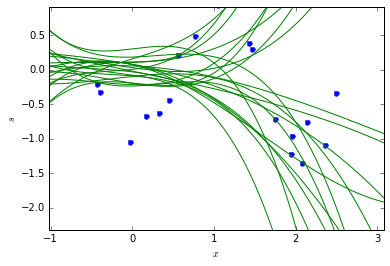

In [2]:
n_points = 20
n_grid = 200
frec = 3
std_n = 0.2
degree = 3
nplots = 20

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_w = 0.03  ### Try increasing this value
var_w = sigma_w * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)

xmin = np.min(X_tr)
xmax = np.max(X_tr)
X_grid = np.linspace(xmin-0.2*(xmax-xmin), xmax+0.2*(xmax-xmin),n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

for k in range(nplots):
    
    #Draw weigths fromt the prior distribution
    w_iter = np.random.multivariate_normal(mean_w,var_w)
    S_grid_iter = np.polyval(w_iter,X_grid)
    ax.plot(X_grid,S_grid_iter,'g-')

ax.set_xlim(xmin-0.2*(xmax-xmin), xmax+0.2*(xmax-xmin))
ax.set_ylim(S_tr[0]-2,S_tr[-1]+2)
ax.set_xlabel('$x$')
ax.set_ylabel('$s$')
plt.show()

### 2.2. Summary

Summarizing, the steps to design a Bayesian parametric regresion algorithm are the following:

1. Assume a parametric data model $p(s| {\bf x},{\bf w})$ and a prior distribution $p({\bf w})$.
2. Using the data model and the i.i.d. assumption, compute $p({\bf s}|{\bf w})$.
3. Applying the bayes rule, compute the posterior distribution $p({\bf w}|{\bf s})$.
4. Compute the MSE estimate of $s$ given ${\bf x}$.

## 3. Bayesian regression for a Gaussian model.

We will apply the above steps to derive a Bayesian regression algorithm for a Gaussian model.

### 3.1. Step 1: The Gaussian model.

Let as assume that the likelihood function is given by the Gaussian model described in Sec. 1.3.2.

$$
s~|~{\bf w} \sim {\cal N}\left({\bf z}^\top{\bf w}, \sigma_\varepsilon^2 {\bf I} \right)
$$

and that the prior is also Gaussian

$$
{\bf w} \sim {\cal N}\left({\bf 0},{\pmb \Sigma}_{p} \right)
$$

### 3.2. Step 2: Complete data likelihood

Using the i.i.d. assumption, 

$$
{\bf s}~|~{\bf w} \sim {\cal N}\left({\bf Z}{\bf w},\sigma_\varepsilon^2 {\bf I} \right)
$$

### 3.3. Step 3: Posterior weight distribution

The posterior distribution of the weights can be computed using the Bayes rule

$$p({\bf w}|{\bf s}) = \frac{p({\bf s}|{\bf w})~p({\bf w})}{p({\bf s})}$$

Since both $p({\bf s}|{\bf w})$ and $p({\bf w})$ follow a Gaussian distribution, we know also that the joint distribution and the posterior distribution of ${\bf w}$ given ${\bf s}$ are also Gaussian. Therefore,

$${\bf w}~|~{\bf s} \sim {\cal N}\left({\bf w}_\text{MSE}, {\pmb\Sigma}_{\bf w}\right)$$

After some algebra, it can be shown that mean and the covariance matrix of the distribution are:

$${\pmb\Sigma}_{\bf w} = \left[\frac{1}{\sigma_\varepsilon^2} {\bf Z}^{\top}{\bf Z} + {\pmb \Sigma}_p^{-1}\right]^{-1}$$

$${\bf w}_\text{MSE} = {\sigma_\varepsilon^{-2}} {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}$$

#### Exercise 1: 

Consider the dataset with one-dimensional inputs given by

In [3]:
# True data parameters
w_true = 3
std_n = 0.4

# Generate the whole dataset
n_max = 64
X_tr = 3 * np.random.random((n_max,1)) - 0.5
S_tr =  w_true * X_tr + std_n * np.random.randn(n_max,1)

Fit a Bayesian linear regression model assuming ${\bf z}={\bf x}$ and

In [4]:
# Model parameters
sigma_eps = 0.1
mean_w = np.zeros((1,))
sigma_p = 1e6 * np.eye(1)

To do so, compute the posterior weight distribution using the first $k$ samples in the complete dataset, for $k = 1,2,4,8,\ldots, 128$. Draw all these posteriors along with the prior distribution in the same plot.

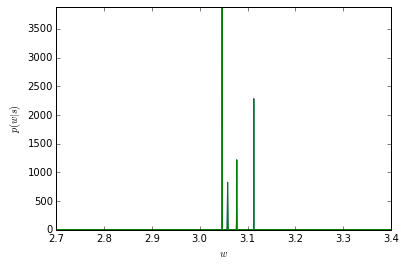

[ 3.04690035]


In [5]:
# No. of points to analyze
n_points = [1, 2, 4, 8, 16, 32, 64]

# Prepare plots
w_grid = np.linspace(2.7, 3.4, 5000)   # Sample the w axiss
plt.figure()

# Plot the prior distribution
# p = <FILL IN>
p = 1.0/(sigma_p*np.sqrt(2*np.pi)) * np.exp(-(w_grid**2)/(2*sigma_p**2))
plt.plot(w_grid, p.flatten(),'g-')

for k in n_points:

    # Select the first k samples
    Zk = X_tr[0:k, :]
    Sk = S_tr[0:k]

    # Compute the parameters of the posterior distribution
    # Sigma_w = <FILL IN>
    # w_MSE = <FILL IN>
    Sigma_w = np.linalg.inv(np.dot(Zk.T, Zk)/(sigma_eps**2) + np.linalg.inv(sigma_p))
    w_MSE = Sigma_w.dot(Zk.T).dot(Sk)/(sigma_eps**2)
    w_MSE = np.array(w_MSE).flatten()

    # Draw weights from the posterior distribution
    # p = <FILL IN>
    p = 1.0/(Sigma_w*np.sqrt(2*np.pi)) * np.exp(-((w_grid-w_MSE)**2)/(2*Sigma_w**2))
    p = p.flatten()
    
    plt.plot(w_grid, p,'g-')
    plt.fill_between(w_grid, 0, p, alpha=0.8, edgecolor='#1B2ACC', facecolor='#089FFF',
        linewidth=1, antialiased=True)
    plt.xlim(w_grid[0], w_grid[-1])
    plt.ylim(0, np.max(p))
    plt.xlabel('$w$')
    plt.ylabel('$p(w|s)$')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)

# Remove the temporary plots and fix the last one
display.clear_output(wait=True)
plt.show()

# Print the weight estimate based on the whole dataset
print w_MSE


#### Exercise 2: 

Note that, in the example above, the model assumptions are correct: the target variables have been generated by a linear model with noise standard deviation `sigma_n` which is exactly equal to the value assumed by the model, stored in variable `sigma_eps`. Check what happens if we take `sigma_eps=4*sigma_n` or `sigma_eps=sigma_n/4`. 

* Does the algorithm fails in that cases?
* What differences can you observe with respect to the ideal case `sigma_eps=sigma_n`?

### 3.4. Step 4: MSE estimate

Noting that 
$$
\mathbb{E}\{s|{\bf w}, {\bf x}\} = {\bf w}^\top {\bf z}
$$

we can write

$$
\hat{s}_\text{MSE} 
   = \int {\bf w}^\top {\bf z} p({\bf w}|{\bf s}) d{\bf w}
   = \left(\int {\bf w} p({\bf w}|{\bf s}) d{\bf w}\right)^\top {\bf z}
   = {\bf w}_\text{MSE}^\top {\bf z}
$$

where
$$
{\bf w}_\text{MSE} 
   = \int {\bf w} p({\bf w}|{\bf s}) d{\bf w}
   = {\sigma_\varepsilon^{-2}} {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}
$$

Therefore, in the Gaussian case, the weighted integration of prediction function is equivalent to apply a unique model, with weights ${\bf w}_\text{MSE}$.

#### Exercise 3:

Plot the minimum MSE predictions of $s$ for inputs $x$ in the interval [-1, 3].

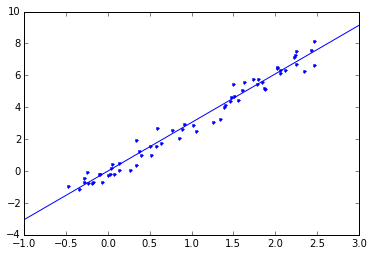

In [6]:
# <SOL>
x = np.array([-1.0, 3.0])
s_pred = w_MSE * x

plt.figure()
plt.plot(X_tr, S_tr,'b.')
plt.plot(x, s_pred)
plt.show()
# </SOL>

### 3.5 Maximum likelihood vs Bayesian Inference.  Making predictions

   - Following an <b>ML approach</b>, we retain a single model, ${\bf w}_{ML} = \arg \max_{\bf w} p({\bf s}|{\bf w})$. Then, the predictive distribution of the target value for a new point would be obtained as:
   
   $$p({s^*}|{\bf w}_{ML},{\bf x}^*) $$
   
   For the generative model of Section 3.1.2 (additive i.i.d. Gaussian noise), this distribution is:
   
   $$p({s^*}|{\bf w}_{ML},{\bf x}^*) = \frac{1}{\sqrt{2\pi\sigma_\varepsilon^2}} \exp \left(-\frac{\left(s^* - {\bf w}_{ML}^\top {\bf z}^*\right)^2}{2 \sigma_\varepsilon^2} \right)$$
   
      * The mean of $s^*$ is just the same as the prediction of the LS model, and the same uncertainty is assumed independently of the observation vector (i.e., the variance of the noise of the model).
      
      * If a single value is to be kept, we would probably keep the mean of the distribution, which is equivalent to the LS prediction.
   
   
   - Using <b>Bayesian inference</b>, we retain all models. Then, the inference of the value $s^* = s({\bf x}^*)$ is carried out by mixing all models, according to the weights given by the posterior distribution.
   
   \begin{align}p({s^*}|{\bf x}^*,{\bf s}) 
                         & = \int p({s^*}~|~{\bf w},{\bf x}^*) p({\bf w}~|~{\bf s}) d{\bf w}\end{align}
   
   where:
   
      * $p({s^*}|{\bf w},{\bf x}^*) = \displaystyle\frac{1}{\sqrt{2\pi\sigma_\varepsilon^2}} \exp \left(-\frac{\left(s^* - {\bf w}^\top {\bf z}^*\right)^2}{2 \sigma_\varepsilon^2} \right)$
      * $p({\bf w}~|~{\bf s})$: Is the posterior distribution of the weights, that can be computed using Bayes' Theorem.

The following fragment of code draws random vectors from $p({\bf w}|{\bf s})$, and plots the corresponding regression curves along with the training points. Compare these curves with those extracted from the prior distribution of ${\bf w}$ and with the LS solution.

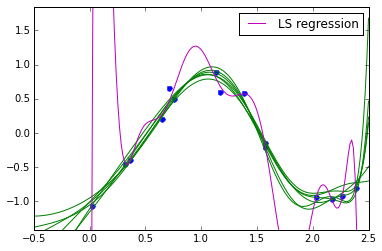

In [7]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 12
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_p = .3 * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-.5,2.5,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

# Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Compute posterior distribution parameters
Sigma_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(sigma_p))
posterior_mean = Sigma_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

for k in range(nplots):
    
    #Draw weights from the posterior distribution
    w_iter = np.random.multivariate_normal(posterior_mean,Sigma_w)
    #Note that polyval assumes the first element of weight vector is the coefficient of
    #the highest degree term. Thus, we need to reverse w_iter
    S_grid_iter = np.polyval(w_iter[::-1],X_grid)
    ax.plot(X_grid,S_grid_iter,'g-')

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)
ax.plot(X_grid,S_grid_iter,'m-',label='LS regression')
    
ax.set_xlim(-.5,2.5)
ax.set_ylim(S_tr[0]-2,S_tr[-1]+2)
ax.legend(loc='best')
plt.show()

#### Posterior distribution of the target 

   - Since $f^* = f({\bf x}^*) = {\bf w}^\top{\bf z}$, $f^*$ is also a Gaussian variable whose posterior mean and variance can be calculated as follows:
   
   $$\mathbb{E}\{{{\bf z}^*}^\top {\bf w}~|~{\bf s}, {\bf z}^*\} = {{\bf z}^*}^\top \mathbb{E}\{{\bf w}|{\bf s}\} = {\sigma_\varepsilon^{-2}} {{\bf z}^*}^\top  {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}$$
   
   $$\text{Cov}\left[{{\bf z}^*}^\top {\bf w}~|~{\bf s}, {\bf z}^*\right] = {{\bf z}^*}^\top \text{Cov}\left[{\bf w}~|~{\bf s}\right] {{\bf z}^*} = {{\bf z}^*}^\top {\pmb \Sigma}_{\bf w} {{\bf z}^*}$$
   
   
   - Therefore, $f^*~|~{\bf s}, {\bf x}^* \sim {\cal N}\left({\sigma_\varepsilon^{-2}} {{\bf z}^*}^\top  {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}, {{\bf z}^*}^\top {\pmb \Sigma}_{\bf w} {{\bf z}^*} \right)$
   
   - Finally, for $s^* = f^* + \varepsilon^*$, the posterior distribution is  $s^*~|~{\bf s}, {\bf z}^* \sim {\cal N}\left({\sigma_\varepsilon^{-2}} {{\bf z}^*}^\top  {\pmb\Sigma}_{\bf w} {\bf Z}^\top {\bf s}, {{\bf z}^*}^\top {\pmb \Sigma}_{\bf w} {{\bf z}^*} + \sigma_\varepsilon^2\right)$

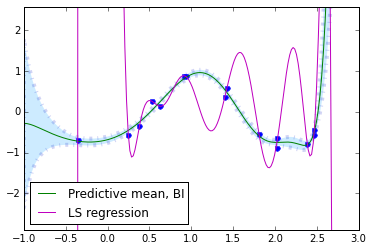

In [8]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 12
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_p = .5 * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-1,3,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Compute posterior distribution parameters
Sigma_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(sigma_p))
posterior_mean = Sigma_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

#Plot the posterior mean
#Note that polyval assumes the first element of weight vector is the coefficient of
#the highest degree term. Thus, we need to reverse w_iter
S_grid_iter = np.polyval(posterior_mean[::-1],X_grid)
ax.plot(X_grid,S_grid_iter,'g-',label='Predictive mean, BI')

#Plot confidence intervals for the Bayesian Inference
std_x = []
for el in X_grid:
    x_ast = np.array([el**k for k in range(degree+1)])
    std_x.append(np.sqrt(x_ast.dot(Sigma_w).dot(x_ast)[0,0]))
std_x = np.array(std_x)
plt.fill_between(X_grid, S_grid_iter-std_x, S_grid_iter+std_x,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)
ax.plot(X_grid,S_grid_iter,'m-',label='LS regression')
    
ax.set_xlim(-1,3)
ax.set_ylim(S_tr[0]-2,S_tr[-1]+2)
ax.legend(loc='best')

Not only do we obtain a better predictive model, but we also have confidence intervals (error bars) for the predictions.

## 4 Maximum evidence model selection

We have already addressed with Bayesian Inference the following two issues:

   - For a given degree, how do we choose the weights?
   
   - Should we focus on just one model, or can we use several models at once?
   
However, we still needed some assumptions: a parametric model (i.e., polynomial function and <i>a priori</i> degree selection) and several parameters needed to be adjusted.

Though we can recur to cross-validation, Bayesian inference opens the door to other strategies. 

   - We could argue that rather than keeping single selections of these parameters, we could use simultaneously several sets of parameters (and/or several parametric forms), and average them in a probabilistic way ... (like we did with the models)
   
   - We will follow a simpler strategy, selecting just the most likely set of parameters according to an ML criterion

### 4.1 Model evidence

The evidence of a model is defined as

$$L = p({\bf s}~|~{\cal M})$$

where ${\cal M}$ denotes the model itself and any free parameters it may have. For instance, for the polynomial model we have assumed so far, ${\cal M}$ would represent the degree of the polynomia, the variance of the additive noise, and the <i>a priori</i> covariance matrix of the weights

Applying the Theorem of Total probability, we can compute the evidence of the model as

$$L = \int p({\bf s}~|~{\bf f},{\cal M}) p({\bf f}~|~{\cal M}) d{\bf f} $$

For the linear model $f({\bf x}) = {\bf w}^\top{\bf z}$, the evidence can be computed as

$$L = \int p({\bf s}~|~{\bf w},{\cal M}) p({\bf w}~|~{\cal M}) d{\bf w} $$

It is important to notice that these probability density functions are exactly the ones we computed on the previous section. We are just making explicit that they depend on a particular model and the selection of its parameters. Therefore:

   - $p({\bf s}~|~{\bf w},{\cal M})$ is the likelihood of ${\bf w}$
   
   - $p({\bf w}~|~{\cal M})$ is the <i>a priori</i> distribution of the weights

### 4.2 Model selection via evidence maximization

   - As we have already mentioned, we could propose a prior distribution for the model parameters, $p({\cal M})$, and use it to infer the posterior. However, this can be very involved (usually no closed-form expressions can be derived)
   
   - Alternatively, maximizing the evidence is normally good enough
   
   $${\cal M}_{ML} = \arg\max_{\cal M} p(s~|~{\cal M})$$
   
Note that we are using the subscript 'ML' because the evidence can also be referred to as the likelihood of the model

### 4.3 Example: Selection of the degree of the polynomia

For the previous example we had (we consider a spherical Gaussian for the weights):

   - ${\bf s}~|~{\bf w},{\cal M}~\sim~{\cal N}\left({\bf Z}{\bf w},\sigma_\varepsilon^2 {\bf I} \right)$
   
   - ${\bf w}~|~{\cal M}~\sim~{\cal N}\left({\bf 0},\sigma_p^2 {\bf I} \right)$
   
In this case, $p({\bf s}~|~{\cal M})$ follows also a Gaussian distribution, and it can be shown that

   - $L = p({\bf s}~|~{\cal M}) = {\cal N}\left({\bf 0},\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I} \right)$
   
If we just pursue the maximization of $L$, this is equivalent to maximizing the log of the evidence

$$\log(L) = -\frac{M}{2} \log(2\pi) -{\frac{1}{2}}\log\mid\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\mid - \frac{1}{2} {\bf s}^\top \left(\sigma_p^2 {\bf Z} {\bf Z}^\top+\sigma_\varepsilon^2 {\bf I}\right)^{-1} {\bf s}$$

where $M$ denotes the length of vector ${\bf z}$ (the degree of the polynomia minus 1).
   
The following fragment of code evaluates the evidence of the model as a function of the degree of the polynomia

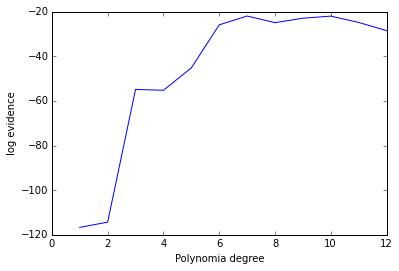

In [9]:
from math import pi

n_points = 15
frec = 3
std_n = 0.2
max_degree = 12

#Prior distribution parameters
sigma_eps = 0.2
mean_w = np.zeros((degree+1,))
sigma_p = 0.5

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Evaluate the posterior evidence

logE = []
for deg in range(max_degree):
    Z_iter = Z[:,:deg+1]
    logE_iter = -((deg+1)*np.log(2*pi)/2) \
                -np.log(np.linalg.det((sigma_p**2)*Z_iter.dot(Z_iter.T) + (sigma_eps**2)*np.eye(n_points)))/2 \
                -S_tr.T.dot(np.linalg.inv((sigma_p**2)*Z_iter.dot(Z_iter.T) + (sigma_eps**2)*np.eye(n_points))).dot(S_tr)/2
    logE.append(logE_iter[0,0])

plt.plot(np.array(range(max_degree))+1,logE)
plt.xlabel('Polynomia degree')
plt.ylabel('log evidence')


The above curve may change the position of its maximum from run to run.

We conclude the notebook by plotting the result of the Bayesian inference for M=6

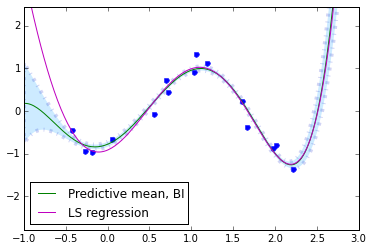

In [10]:
n_points = 15
n_grid = 200
frec = 3
std_n = 0.2
degree = 5 #M-1
nplots = 6

#Prior distribution parameters
sigma_eps = 0.1
mean_w = np.zeros((degree+1,))
sigma_p = .5 * np.eye(degree+1)

X_tr = 3 * np.random.random((n_points,1)) - 0.5
S_tr = - np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)
X_grid = np.linspace(-1,3,n_grid)
S_grid = - np.cos(frec*X_grid) #Noise free for the true model

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_tr,S_tr,'b.',markersize=10)

#Compute matrix with training input data for the polynomial model
Z = []
for x_val in X_tr.tolist():
    Z.append([x_val[0]**k for k in range(degree+1)])
Z=np.asmatrix(Z)

#Compute posterior distribution parameters
Sigma_w = np.linalg.inv(np.dot(Z.T,Z)/(sigma_eps**2) + np.linalg.inv(sigma_p))
posterior_mean = Sigma_w.dot(Z.T).dot(S_tr)/(sigma_eps**2)
posterior_mean = np.array(posterior_mean).flatten()

#Plot the posterior mean
#Note that polyval assumes the first element of weight vector is the coefficient of
#the highest degree term. Thus, we need to reverse w_iter
S_grid_iter = np.polyval(posterior_mean[::-1],X_grid)
ax.plot(X_grid,S_grid_iter,'g-',label='Predictive mean, BI')

#Plot confidence intervals for the Bayesian Inference
std_x = []
for el in X_grid:
    x_ast = np.array([el**k for k in range(degree+1)])
    std_x.append(np.sqrt(x_ast.dot(Sigma_w).dot(x_ast)[0,0]))
std_x = np.array(std_x)
plt.fill_between(X_grid, S_grid_iter-std_x, S_grid_iter+std_x,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

#We plot also the least square solution
w_LS = np.polyfit(X_tr.flatten(), S_tr.flatten(), degree)
S_grid_iter = np.polyval(w_LS,X_grid)
ax.plot(X_grid,S_grid_iter,'m-',label='LS regression')
    
ax.set_xlim(-1,3)
ax.set_ylim(S_tr[0]-2,S_tr[-1]+2)
ax.legend(loc='best')

We can check, that now the model also seems quite appropriate for LS regression, but keep in mind that selection of such parameter was itself carried out using Bayesian inference.